In [1]:
# Data and dependencies

from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model

import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalisation
x_train = x_train.astype('float32') / 255 # 255 max rgb value
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:]))
x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:]))

input_dim = x_train.shape[1]

Using TensorFlow backend.


In [2]:
# parameters
intermediate_dim = 512 # dimension of points in the latent space
batch_size = 128 
latent_dim = 2 # the two latent parameters z_mean and z_sigma

In [3]:
# architecture

inputs = Input(shape=(input_dim, ), name='encoder_input')

# encoder (x -> z_mean & x -> z_log_var) A 'Y' shape
encoder_1 = Dense(intermediate_dim, activation='relu')
encoder_out_1 = encoder_1(inputs)
z_mean = Dense(latent_dim, name='z_mean')
z_mean_out = z_mean(encoder_out_1)
z_log_sigma = Dense(latent_dim, name='z_log_sigma')
z_log_sigma_out = z_log_sigma(encoder_out_1)

In [4]:
# sampling
from keras import backend as K # operations with tensors

def sampling(params):
    z_mean, z_log_sigma = params
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim)) # mean = 0, std = 1
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon #

# We need to wrap the output of sampling into a layer for connecting it with the decoder. For that we can
# a Lambda layer
from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim, ))
z_out = z([z_mean_out, z_log_sigma_out])

In [5]:
# decoder
decoder_1 = Dense(intermediate_dim, activation='relu')
decoder_2 = Dense(input_dim, activation='sigmoid')
decoder_1_out = decoder_1(z_out)
decoder_2_out = decoder_2(decoder_1_out)

In [6]:
# models

# end-to-end autoencoder
vae = Model(inputs, decoder_2_out) 

# from inputs to latent space
encoder_model = Model(inputs, z_mean_out) 

# generator
decoder_input = Input(shape=(latent_dim, ))
#_decoder_1_out = decoder_1(decoder_input)
#_decoder_2_out = decoder_2(_decoder_1_out)
generator = Model(decoder_input, decoder_2(decoder_1(decoder_input)))

In [7]:
# loss
from keras.losses import binary_crossentropy

# Reconstruction loss and KL divergence
def vae_loss(true, pred):
    l_re = binary_crossentropy(true, pred) * input_dim
    d_kl = - 0.5 * K.mean(1 + z_log_sigma_out - K.square(z_mean_out) - K.exp(z_log_sigma_out), axis=-1)

    loss = l_re + d_kl
    return loss

vae.compile(optimizer='adam', loss=vae_loss)

In [8]:
# train 
vae.fit(x_train, x_train,
       shuffle=True,
       epochs=20,
       batch_size=batch_size,
       validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 11s 178us/step - loss: 192.1246 - val_loss: 168.5450
Epoch 2/20
60000/60000 [==============================] - 11s 176us/step - loss: 165.2133 - val_loss: 163.0971
Epoch 3/20
60000/60000 [==============================] - 10s 172us/step - loss: 161.1614 - val_loss: 160.0831
Epoch 4/20
60000/60000 [==============================] - 11s 182us/step - loss: 158.6624 - val_loss: 157.9445
Epoch 5/20
60000/60000 [==============================] - 11s 183us/step - loss: 156.8188 - val_loss: 156.4506
Epoch 6/20
60000/60000 [==============================] - 11s 179us/step - loss: 155.4659 - val_loss: 155.2234
Epoch 7/20
60000/60000 [==============================] - 11s 182us/step - loss: 154.4219 - val_loss: 154.2909
Epoch 8/20
60000/60000 [==============================] - 11s 186us/step - loss: 153.4920 - val_loss: 153.6441
Epoch 9/20
60000/60000 [==============================] - 11s 

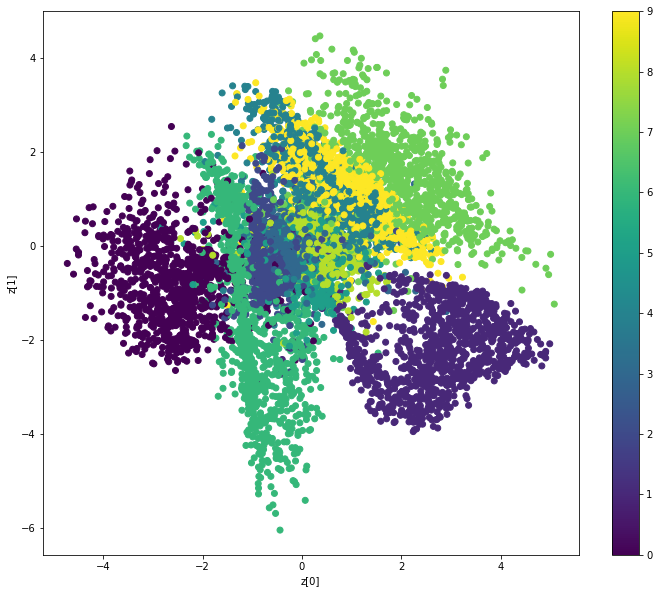

In [9]:
x_test_encoded = encoder_model.predict(x_test, batch_size=batch_size)

# distributions of the different classes
plt.figure(figsize=(12, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


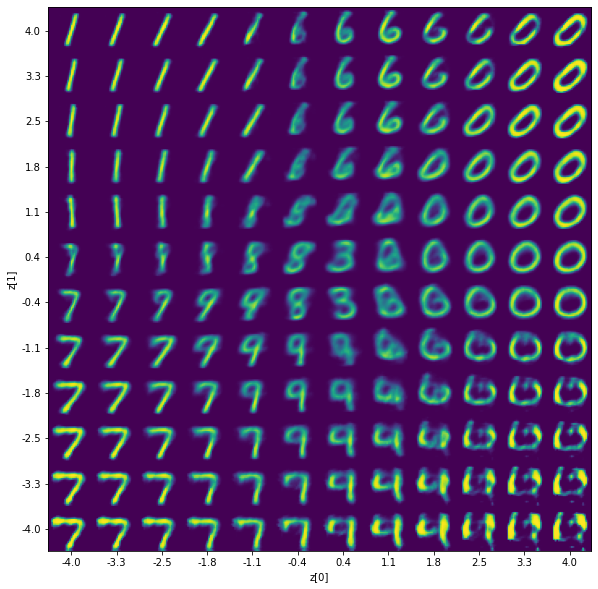

In [10]:
# display generator usin random values within the interval
# shown by the encoder [-4,4]

n = 12  # figure with 12x12 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# we will sample n points within [-4, 4] standard deviations
grid_x = np.linspace(-4, 4, n) # value obtain with the encoder
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))

# axis labels 
start_range = digit_size // 2
end_range = (n - 1) * digit_size + start_range + 1

pixel_range = np.arange(start_range, end_range, digit_size)

sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)

plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")

plt.imshow(figure)
plt.show()